In [1]:
# 1Ô∏è‚É£ Cargar datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuraci√≥n para Visual Studio Code
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("=" * 60)
print("TASK 2: SIMPLE SALES FORECAST WITH MOVING AVERAGE")
print("=" * 60)

# Definir rutas
base_dir = r"C:\Users\Mario Leyser\PROYECTO_BASE\Interboot\INTERBOOT"
processed_path = os.path.join(base_dir, "data", "processed")
plots_path = os.path.join(base_dir, "plots")
models_path = os.path.join(base_dir, "models")

# Crear directorios necesarios
os.makedirs(models_path, exist_ok=True)
os.makedirs(plots_path, exist_ok=True)

# Cargar datos limpios del Task 1
try:
    clean_data_path = os.path.join(processed_path, 'sales_data_cleaned.csv')
    df = pd.read_csv(clean_data_path, parse_dates=['date'])
    print("‚úì Datos limpios cargados exitosamente")
    print(f"Dimensiones: {df.shape}")
except FileNotFoundError:
    print("No se encontraron datos limpios. Cargando datos originales...")
    # Si no existen datos limpios, cargar y limpiar los originales
    raw_path = os.path.join(base_dir, "data", "raw", "train.csv")
    df = pd.read_csv(raw_path, parse_dates=['date'])
    print("‚úì Datos originales cargados")

print(f"\nPeriodo de datos: {df['date'].min()} to {df['date'].max()}")

# Preparar datos para an√°lisis de series temporales
print("\n" + "=" * 60)
print("PREPARANDO DATOS PARA AN√ÅLISIS DE SERIES TEMPORALES")
print("=" * 60)

# Agrupar ventas por fecha (ventas diarias totales)
daily_sales = df.groupby('date')['sales'].sum().reset_index()
daily_sales = daily_sales.sort_values('date')
daily_sales = daily_sales.set_index('date')

print(f"Ventas diarias totales: {len(daily_sales)} d√≠as")
print(f"Rango: {daily_sales.index.min()} to {daily_sales.index.max()}")

# Calcular algunas estad√≠sticas b√°sicas
print(f"\nEstad√≠sticas de ventas diarias:")
print(f"‚Ä¢ Promedio diario: ${daily_sales['sales'].mean():,.2f}")
print(f"‚Ä¢ Mediana diaria: ${daily_sales['sales'].median():,.2f}")
print(f"‚Ä¢ Desviaci√≥n est√°ndar: ${daily_sales['sales'].std():,.2f}")
print(f"‚Ä¢ M√°ximo diario: ${daily_sales['sales'].max():,.2f}")
print(f"‚Ä¢ M√≠nimo diario: ${daily_sales['sales'].min():,.2f}")


TASK 2: SIMPLE SALES FORECAST WITH MOVING AVERAGE
‚úì Datos limpios cargados exitosamente
Dimensiones: (3000888, 9)

Periodo de datos: 2013-01-01 00:00:00 to 2017-08-15 00:00:00

PREPARANDO DATOS PARA AN√ÅLISIS DE SERIES TEMPORALES
Ventas diarias totales: 1684 d√≠as
Rango: 2013-01-01 00:00:00 to 2017-08-15 00:00:00

Estad√≠sticas de ventas diarias:
‚Ä¢ Promedio diario: $637,556.38
‚Ä¢ Mediana diaria: $632,188.86
‚Ä¢ Desviaci√≥n est√°ndar: $234,410.24
‚Ä¢ M√°ximo diario: $1,463,083.96
‚Ä¢ M√≠nimo diario: $2,511.62


In [2]:

# 2Ô∏è‚É£ Calcular medias m√≥viles
print("\n" + "=" * 60)
print("CALCULANDO MEDIAS M√ìVILES")
print("=" * 60)

# Crear una copia para trabajar
sales_ts = daily_sales.copy()

# Medias m√≥viles para diferentes ventanas temporales
windows = {
    '7_days': 7,      # Semanal
    '14_days': 14,    # Bisemanal
    '30_days': 30,    # Mensual
    '60_days': 60,    # Bimestral
    '90_days': 90     # Trimestral
}

print("Calculando medias m√≥viles...")
for name, window in windows.items():
    sales_ts[f'ma_{name}'] = sales_ts['sales'].rolling(window=window, center=False).mean()
    print(f"‚úì Media m√≥vil {window} d√≠as ({name}): calculada")

# Media m√≥vil exponencial (da m√°s peso a observaciones recientes)
sales_ts['ema_7'] = sales_ts['sales'].ewm(span=7, adjust=False).mean()
sales_ts['ema_30'] = sales_ts['sales'].ewm(span=30, adjust=False).mean()
print("‚úì Medias m√≥viles exponenciales calculadas")

# Calcular m√©tricas de error para las medias m√≥viles
def calculate_metrics(actual, predicted):
    """Calcular m√©tricas de error"""
    mask = ~np.isnan(predicted)
    actual = actual[mask]
    predicted = predicted[mask]
    
    if len(actual) == 0:
        return np.nan, np.nan, np.nan
    
    mae = np.mean(np.abs(actual - predicted))
    mse = np.mean((actual - predicted) ** 2)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse

# Calcular m√©tricas para cada media m√≥vil
metrics_results = {}
for col in sales_ts.columns:
    if col.startswith('ma_') or col.startswith('ema_'):
        mae, mse, rmse = calculate_metrics(sales_ts['sales'].values, sales_ts[col].values)
        metrics_results[col] = {
            'MAE': mae,
            'MSE': mse, 
            'RMSE': rmse
        }

print("\nM√©tricas de error para medias m√≥viles:")
for method, metrics in metrics_results.items():
    if not np.isnan(metrics['RMSE']):
        print(f"  {method:10}: RMSE = ${metrics['RMSE']:,.2f}")

# Preparar datos para forecasting
# Dividir en train y test (√∫ltimos 30 d√≠as para test)
test_days = 30
train_data = sales_ts.iloc[:-test_days]
test_data = sales_ts.iloc[-test_days:]

print(f"\nDivisi√≥n train/test:")
print(f"‚Ä¢ Per√≠odo de entrenamiento: {len(train_data)} d√≠as")
print(f"‚Ä¢ Per√≠odo de prueba: {len(test_data)} d√≠as")
print(f"‚Ä¢ Fechas test: {test_data.index.min()} to {test_data.index.max()}")

# Forecasting simple usando la √∫ltima media m√≥vil disponible
last_ma_7 = train_data['ma_7_days'].iloc[-1]
last_ma_30 = train_data['ma_30_days'].iloc[-1]

# Crear pron√≥sticos naive (usando la √∫ltima media m√≥vil disponible)
forecast_ma_7 = [last_ma_7] * test_days
forecast_ma_30 = [last_ma_30] * test_days



CALCULANDO MEDIAS M√ìVILES
Calculando medias m√≥viles...
‚úì Media m√≥vil 7 d√≠as (7_days): calculada
‚úì Media m√≥vil 14 d√≠as (14_days): calculada
‚úì Media m√≥vil 30 d√≠as (30_days): calculada
‚úì Media m√≥vil 60 d√≠as (60_days): calculada
‚úì Media m√≥vil 90 d√≠as (90_days): calculada
‚úì Medias m√≥viles exponenciales calculadas

M√©tricas de error para medias m√≥viles:
  ma_7_days : RMSE = $138,030.54
  ma_14_days: RMSE = $145,104.31
  ma_30_days: RMSE = $148,521.83
  ma_60_days: RMSE = $158,432.80
  ma_90_days: RMSE = $162,442.45
  ema_7     : RMSE = $115,224.08
  ema_30    : RMSE = $143,956.09

Divisi√≥n train/test:
‚Ä¢ Per√≠odo de entrenamiento: 1654 d√≠as
‚Ä¢ Per√≠odo de prueba: 30 d√≠as
‚Ä¢ Fechas test: 2017-07-17 00:00:00 to 2017-08-15 00:00:00



VISUALIZANDO TENDENCIAS Y PRON√ìSTICOS


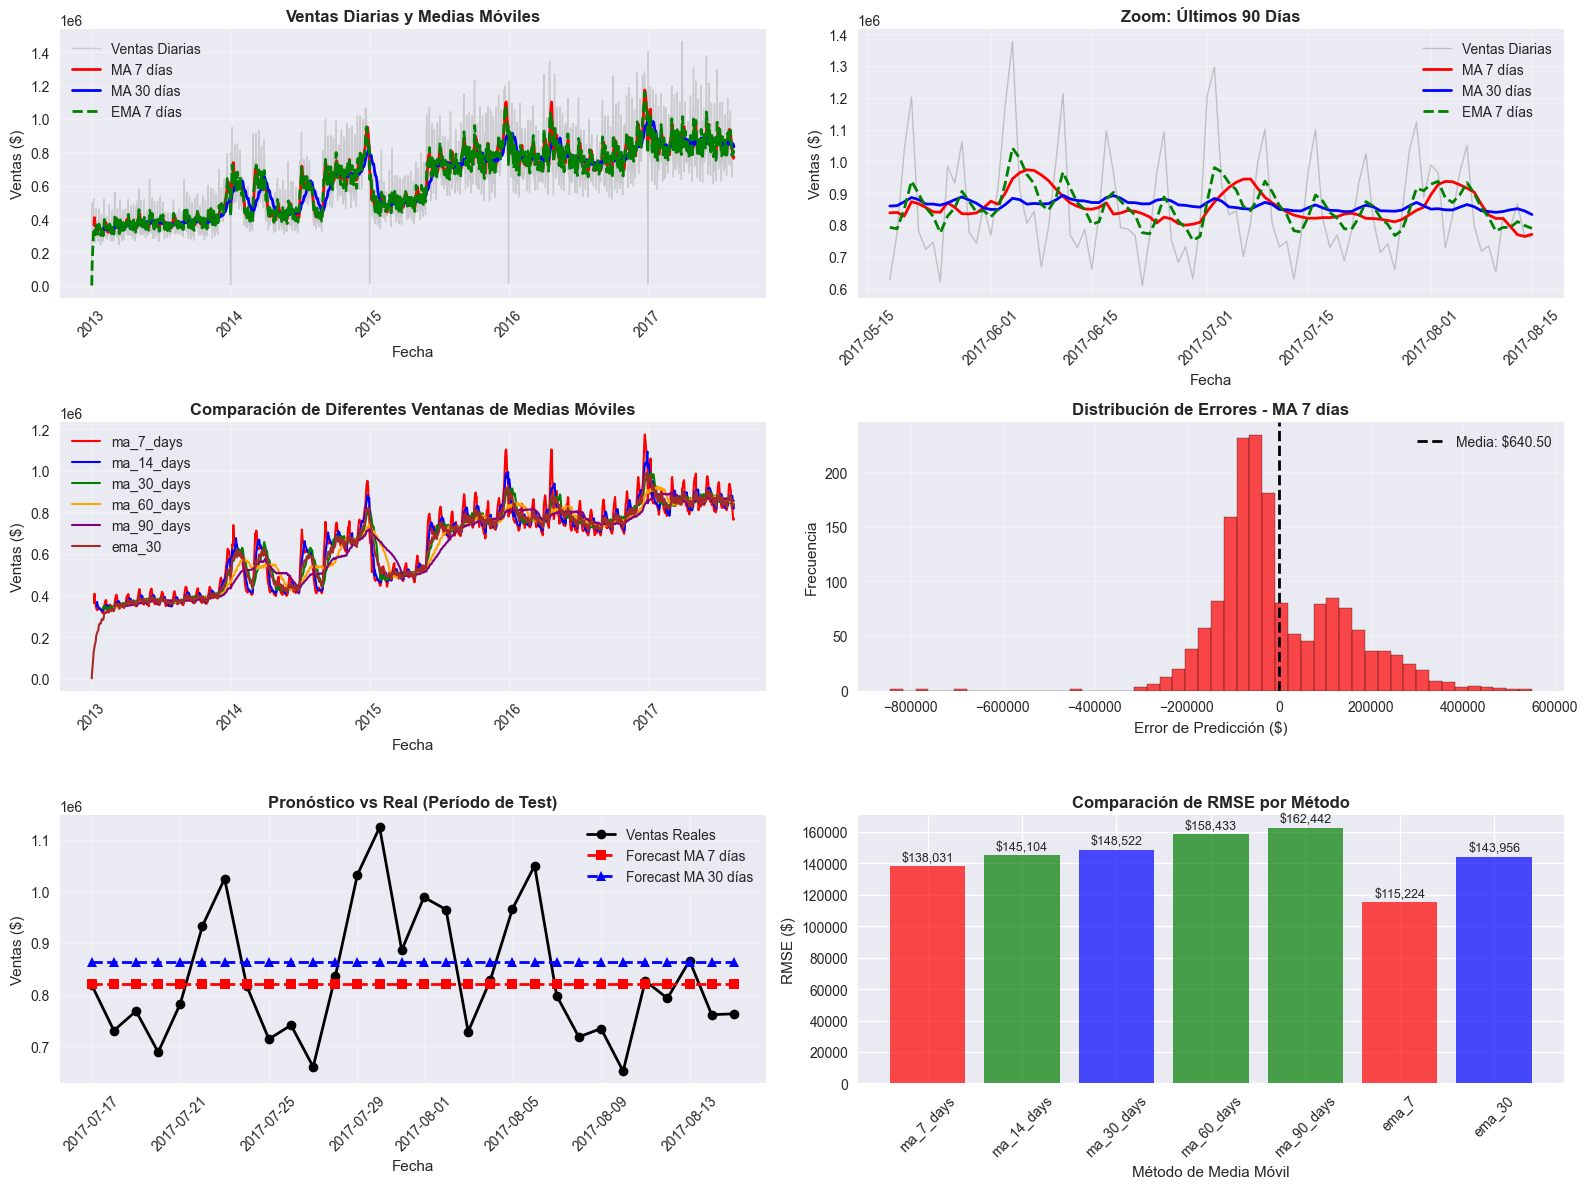

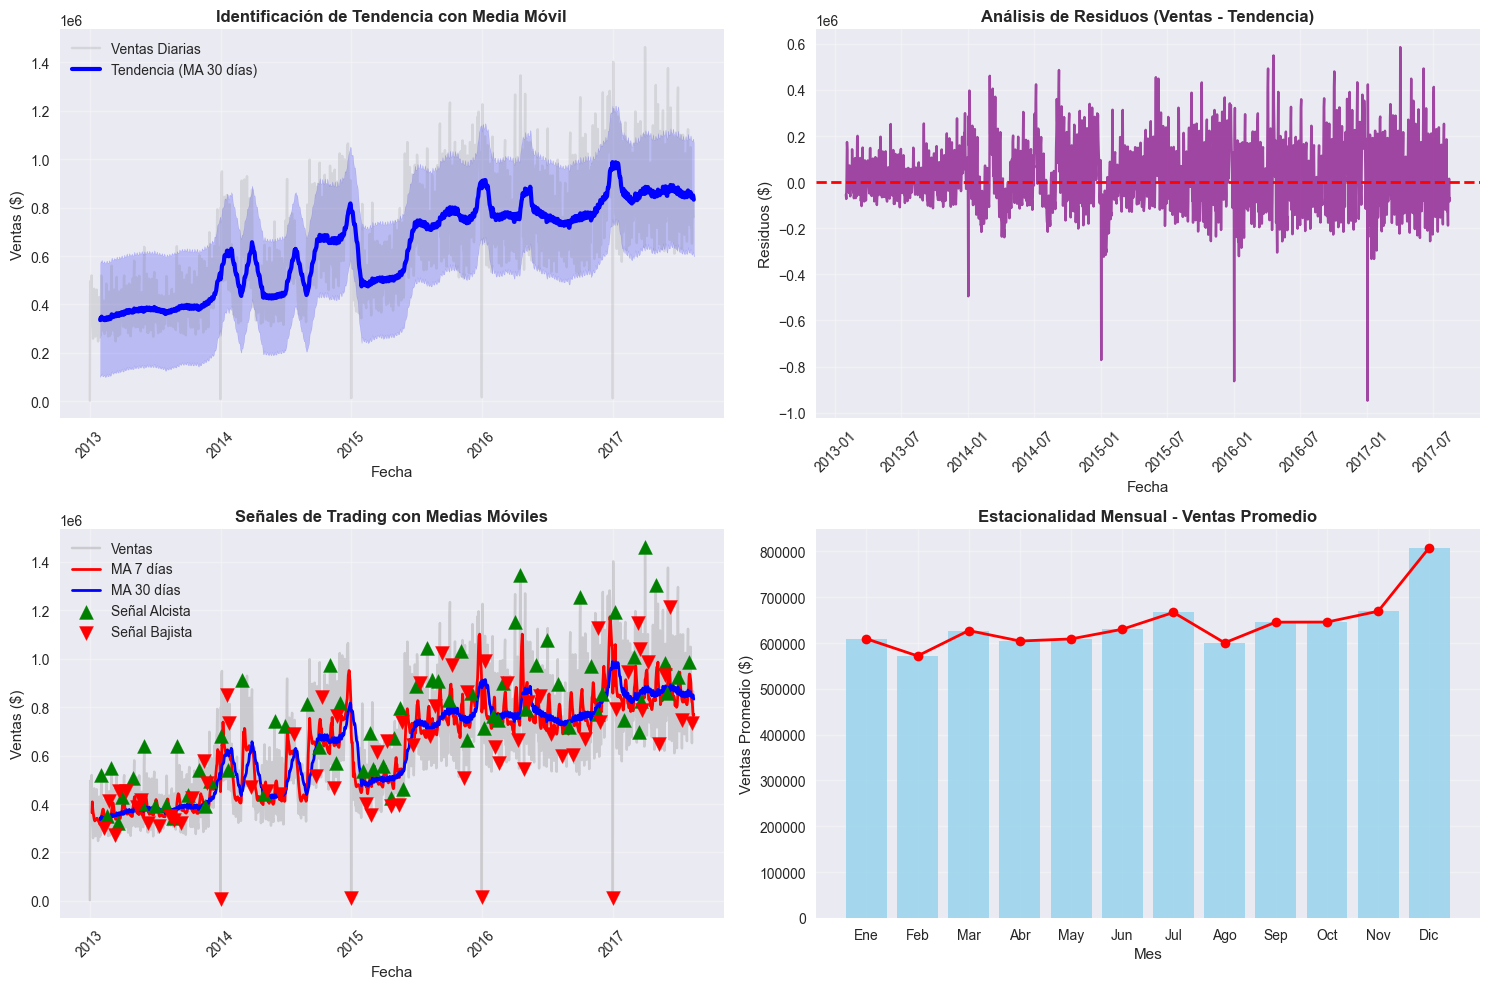


GUARDANDO RESULTADOS
‚úì Dataset con medias m√≥viles guardado: C:\Users\Mario Leyser\PROYECTO_BASE\Interboot\INTERBOOT\data\processed\sales_with_moving_averages.csv
‚úì M√©tricas de medias m√≥viles guardadas: C:\Users\Mario Leyser\PROYECTO_BASE\Interboot\INTERBOOT\data\processed\moving_average_metrics.csv

Guardando gr√°ficas...
‚úì Gr√°fica de tendencias guardada: C:\Users\Mario Leyser\PROYECTO_BASE\Interboot\INTERBOOT\plots\moving_averages_trend.png
‚úì Gr√°fica de forecast guardada: C:\Users\Mario Leyser\PROYECTO_BASE\Interboot\INTERBOOT\plots\forecast_vs_actual.png

RESUMEN EJECUTIVO - MOVING AVERAGE FORECAST

üìä RESULTADOS PRINCIPALES:
   ‚Ä¢ Per√≠odo analizado: 1684 d√≠as
   ‚Ä¢ Ventas diarias promedio: $637,556.38
   ‚Ä¢ Mejor media m√≥vil (menor RMSE): ema_7

üéØ INSIGHTS DE MEDIAS M√ìVILES:
   ‚Ä¢ Media m√≥vil 7 d√≠as: Suaviza el ruido, buena para tendencias cortas
   ‚Ä¢ Media m√≥vil 30 d√≠as: Mejor para identificar tendencias a largo plazo
   ‚Ä¢ EMA (Exponential MA): Re

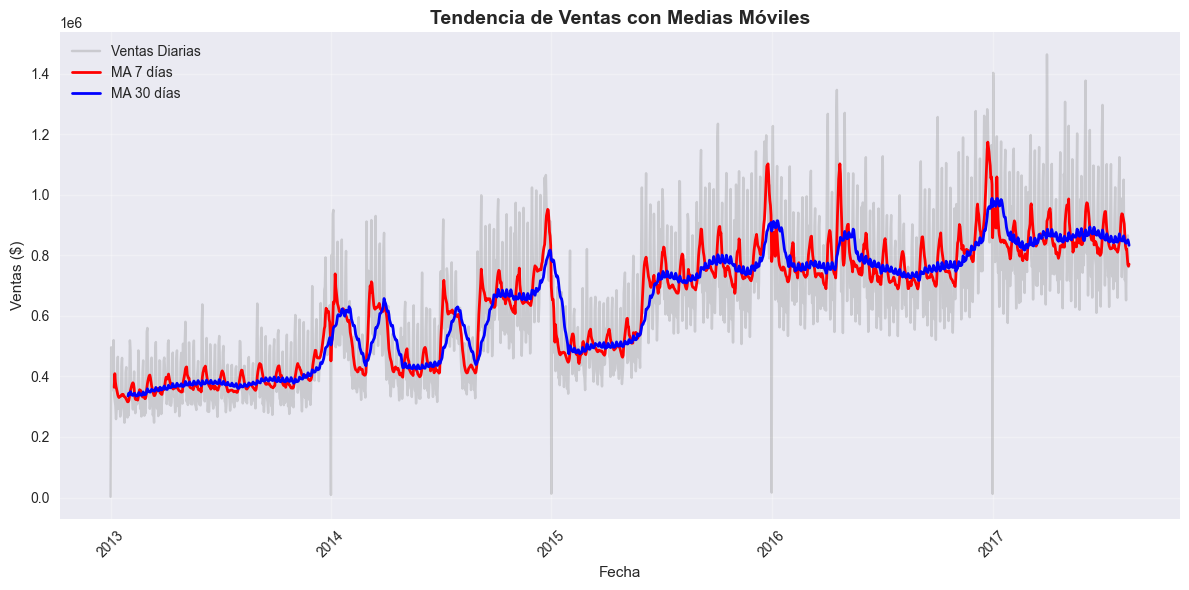

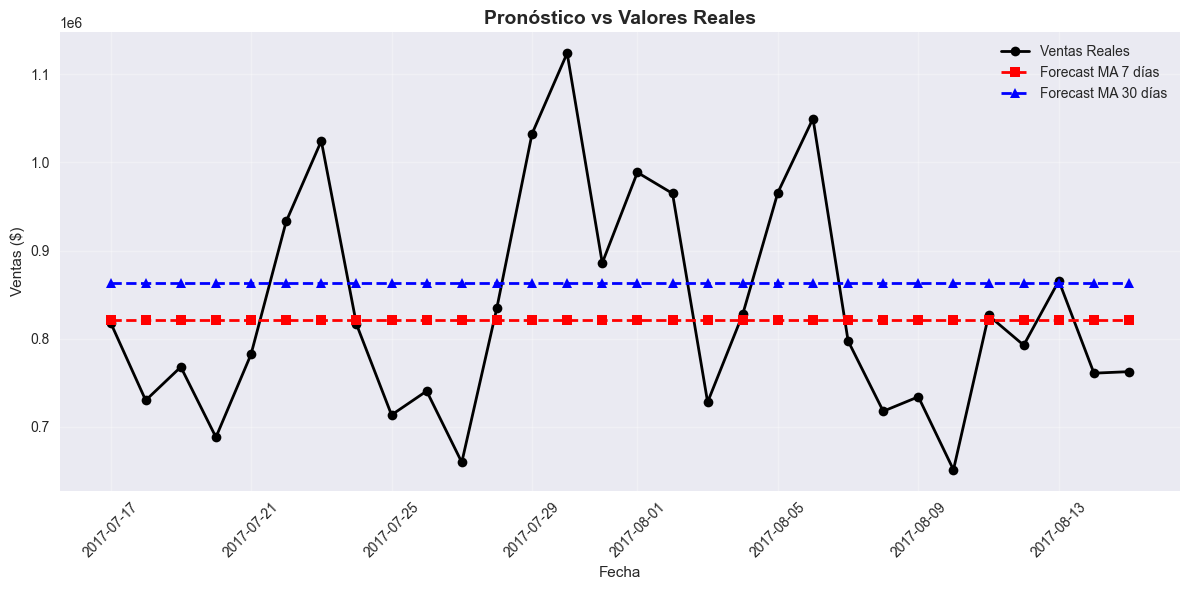

In [3]:

# 3Ô∏è‚É£ Visualizar tendencia
print("\n" + "=" * 60)
print("VISUALIZANDO TENDENCIAS Y PRON√ìSTICOS")
print("=" * 60)

# Visualizaci√≥n 1: Comparaci√≥n de diferentes medias m√≥viles
plt.figure(figsize=(16, 12))

# 1.1 Serie original vs medias m√≥viles (todo el per√≠odo)
plt.subplot(3, 2, 1)
plt.plot(sales_ts.index, sales_ts['sales'], alpha=0.3, color='gray', label='Ventas Diarias', linewidth=1)
plt.plot(sales_ts.index, sales_ts['ma_7_days'], color='red', linewidth=2, label='MA 7 d√≠as')
plt.plot(sales_ts.index, sales_ts['ma_30_days'], color='blue', linewidth=2, label='MA 30 d√≠as')
plt.plot(sales_ts.index, sales_ts['ema_7'], color='green', linewidth=2, label='EMA 7 d√≠as', linestyle='--')
plt.title('Ventas Diarias y Medias M√≥viles', fontweight='bold', fontsize=12)
plt.xlabel('Fecha')
plt.ylabel('Ventas ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 1.2 Zoom en los √∫ltimos 90 d√≠as
plt.subplot(3, 2, 2)
recent_data = sales_ts.tail(90)
plt.plot(recent_data.index, recent_data['sales'], alpha=0.4, color='gray', label='Ventas Diarias', linewidth=1)
plt.plot(recent_data.index, recent_data['ma_7_days'], color='red', linewidth=2, label='MA 7 d√≠as')
plt.plot(recent_data.index, recent_data['ma_30_days'], color='blue', linewidth=2, label='MA 30 d√≠as')
plt.plot(recent_data.index, recent_data['ema_7'], color='green', linewidth=2, label='EMA 7 d√≠as', linestyle='--')
plt.title('Zoom: √öltimos 90 D√≠as', fontweight='bold', fontsize=12)
plt.xlabel('Fecha')
plt.ylabel('Ventas ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 1.3 Comparaci√≥n de todas las medias m√≥viles
plt.subplot(3, 2, 3)
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
for i, (name, color) in enumerate(zip(['ma_7_days', 'ma_14_days', 'ma_30_days', 'ma_60_days', 'ma_90_days', 'ema_30'], colors)):
    plt.plot(sales_ts.index, sales_ts[name], color=color, linewidth=1.5, label=name)
plt.title('Comparaci√≥n de Diferentes Ventanas de Medias M√≥viles', fontweight='bold', fontsize=12)
plt.xlabel('Fecha')
plt.ylabel('Ventas ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 1.4 Distribuci√≥n de errores (MA 7 d√≠as)
plt.subplot(3, 2, 4)
errors_ma7 = sales_ts['sales'] - sales_ts['ma_7_days']
errors_ma7 = errors_ma7.dropna()
plt.hist(errors_ma7, bins=50, alpha=0.7, color='red', edgecolor='black')
plt.axvline(errors_ma7.mean(), color='black', linestyle='--', linewidth=2, label=f'Media: ${errors_ma7.mean():.2f}')
plt.title('Distribuci√≥n de Errores - MA 7 d√≠as', fontweight='bold', fontsize=12)
plt.xlabel('Error de Predicci√≥n ($)')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True, alpha=0.3)

# 1.5 Forecast vs Actual (per√≠odo de test)
plt.subplot(3, 2, 5)
plt.plot(test_data.index, test_data['sales'], color='black', linewidth=2, label='Ventas Reales', marker='o')
plt.plot(test_data.index, forecast_ma_7, color='red', linewidth=2, label='Forecast MA 7 d√≠as', linestyle='--', marker='s')
plt.plot(test_data.index, forecast_ma_30, color='blue', linewidth=2, label='Forecast MA 30 d√≠as', linestyle='--', marker='^')
plt.title('Pron√≥stico vs Real (Per√≠odo de Test)', fontweight='bold', fontsize=12)
plt.xlabel('Fecha')
plt.ylabel('Ventas ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 1.6 M√©tricas de error comparativas
plt.subplot(3, 2, 6)
methods = []
rmse_values = []
for method, metrics in metrics_results.items():
    if not np.isnan(metrics['RMSE']):
        methods.append(method)
        rmse_values.append(metrics['RMSE'])

if methods:
    colors = ['red' if '7' in method else 'blue' if '30' in method else 'green' for method in methods]
    bars = plt.bar(methods, rmse_values, color=colors, alpha=0.7)
    plt.title('Comparaci√≥n de RMSE por M√©todo', fontweight='bold', fontsize=12)
    plt.xlabel('M√©todo de Media M√≥vil')
    plt.ylabel('RMSE ($)')
    plt.xticks(rotation=45)
    
    # A√±adir valores en las barras
    for bar, value in zip(bars, rmse_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(rmse_values)*0.01, 
                f'${value:,.0f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Visualizaci√≥n 2: An√°lisis de tendencias y estacionalidad
plt.figure(figsize=(15, 10))

# 2.1 Tendencia con media m√≥vil de 30 d√≠as
plt.subplot(2, 2, 1)
plt.plot(sales_ts.index, sales_ts['sales'], alpha=0.2, color='gray', label='Ventas Diarias')
plt.plot(sales_ts.index, sales_ts['ma_30_days'], color='blue', linewidth=3, label='Tendencia (MA 30 d√≠as)')
plt.fill_between(sales_ts.index, sales_ts['ma_30_days'] - sales_ts['sales'].std(), 
                 sales_ts['ma_30_days'] + sales_ts['sales'].std(), alpha=0.2, color='blue')
plt.title('Identificaci√≥n de Tendencia con Media M√≥vil', fontweight='bold', fontsize=12)
plt.xlabel('Fecha')
plt.ylabel('Ventas ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 2.2 An√°lisis de residuos (ventas - tendencia)
plt.subplot(2, 2, 2)
residuals = sales_ts['sales'] - sales_ts['ma_30_days']
residuals = residuals.dropna()
plt.plot(residuals.index, residuals.values, color='purple', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('An√°lisis de Residuos (Ventas - Tendencia)', fontweight='bold', fontsize=12)
plt.xlabel('Fecha')
plt.ylabel('Residuos ($)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 2.3 Media m√≥vil adaptativa (comparaci√≥n de ventanas)
plt.subplot(2, 2, 3)
short_window = 7
long_window = 30

# Se√±al de trading simple: cuando MA corta cruza por encima de MA larga
buy_signal = (sales_ts[f'ma_{short_window}_days'] > sales_ts[f'ma_{long_window}_days']) & \
             (sales_ts[f'ma_{short_window}_days'].shift(1) <= sales_ts[f'ma_{long_window}_days'].shift(1))

sell_signal = (sales_ts[f'ma_{short_window}_days'] < sales_ts[f'ma_{long_window}_days']) & \
              (sales_ts[f'ma_{short_window}_days'].shift(1) >= sales_ts[f'ma_{long_window}_days'].shift(1))

plt.plot(sales_ts.index, sales_ts['sales'], alpha=0.3, color='gray', label='Ventas')
plt.plot(sales_ts.index, sales_ts[f'ma_{short_window}_days'], color='red', linewidth=2, label=f'MA {short_window} d√≠as')
plt.plot(sales_ts.index, sales_ts[f'ma_{long_window}_days'], color='blue', linewidth=2, label=f'MA {long_window} d√≠as')

# Marcar se√±ales de compra/venta
buy_dates = sales_ts.index[buy_signal]
sell_dates = sales_ts.index[sell_signal]

plt.scatter(buy_dates, sales_ts.loc[buy_dates, 'sales'], color='green', s=100, marker='^', label='Se√±al Alcista', zorder=5)
plt.scatter(sell_dates, sales_ts.loc[sell_dates, 'sales'], color='red', s=100, marker='v', label='Se√±al Bajista', zorder=5)

plt.title('Se√±ales de Trading con Medias M√≥viles', fontweight='bold', fontsize=12)
plt.xlabel('Fecha')
plt.ylabel('Ventas ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 2.4 An√°lisis de performance por estacionalidad
plt.subplot(2, 2, 4)
sales_ts['month'] = sales_ts.index.month
monthly_avg = sales_ts.groupby('month')['sales'].mean()
months = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
monthly_avg.index = months

plt.bar(months, monthly_avg.values, color='skyblue', alpha=0.7)
plt.plot(months, monthly_avg.values, color='red', marker='o', linewidth=2)
plt.title('Estacionalidad Mensual - Ventas Promedio', fontweight='bold', fontsize=12)
plt.xlabel('Mes')
plt.ylabel('Ventas Promedio ($)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Guardar resultados
print("\n" + "=" * 60)
print("GUARDANDO RESULTADOS")
print("=" * 60)

# Guardar dataset con medias m√≥viles
moving_avg_path = os.path.join(processed_path, 'sales_with_moving_averages.csv')
sales_ts.to_csv(moving_avg_path)
print(f"‚úì Dataset con medias m√≥viles guardado: {moving_avg_path}")

# Guardar m√©tricas
metrics_df = pd.DataFrame(metrics_results).T
metrics_path = os.path.join(processed_path, 'moving_average_metrics.csv')
metrics_df.to_csv(metrics_path)
print(f"‚úì M√©tricas de medias m√≥viles guardadas: {metrics_path}")

# Guardar gr√°ficas principales
print("\nGuardando gr√°ficas...")

# Gr√°fica 1: Tendencia principal
plot1_path = os.path.join(plots_path, 'moving_averages_trend.png')
plt.figure(figsize=(12, 6))
plt.plot(sales_ts.index, sales_ts['sales'], alpha=0.3, color='gray', label='Ventas Diarias')
plt.plot(sales_ts.index, sales_ts['ma_7_days'], color='red', linewidth=2, label='MA 7 d√≠as')
plt.plot(sales_ts.index, sales_ts['ma_30_days'], color='blue', linewidth=2, label='MA 30 d√≠as')
plt.title('Tendencia de Ventas con Medias M√≥viles', fontweight='bold', fontsize=14)
plt.xlabel('Fecha')
plt.ylabel('Ventas ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(plot1_path, dpi=300, bbox_inches='tight')
print(f"‚úì Gr√°fica de tendencias guardada: {plot1_path}")

# Gr√°fica 2: Forecast vs Actual
plot2_path = os.path.join(plots_path, 'forecast_vs_actual.png')
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['sales'], color='black', linewidth=2, label='Ventas Reales', marker='o')
plt.plot(test_data.index, forecast_ma_7, color='red', linewidth=2, label='Forecast MA 7 d√≠as', linestyle='--', marker='s')
plt.plot(test_data.index, forecast_ma_30, color='blue', linewidth=2, label='Forecast MA 30 d√≠as', linestyle='--', marker='^')
plt.title('Pron√≥stico vs Valores Reales', fontweight='bold', fontsize=14)
plt.xlabel('Fecha')
plt.ylabel('Ventas ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(plot2_path, dpi=300, bbox_inches='tight')
print(f"‚úì Gr√°fica de forecast guardada: {plot2_path}")

# Resumen ejecutivo
print("\n" + "=" * 60)
print("RESUMEN EJECUTIVO - MOVING AVERAGE FORECAST")
print("=" * 60)

print(f"\nüìä RESULTADOS PRINCIPALES:")
print(f"   ‚Ä¢ Per√≠odo analizado: {len(sales_ts)} d√≠as")
print(f"   ‚Ä¢ Ventas diarias promedio: ${sales_ts['sales'].mean():,.2f}")
print(f"   ‚Ä¢ Mejor media m√≥vil (menor RMSE): {min(metrics_results, key=lambda x: metrics_results[x]['RMSE'])}")

best_method = min(metrics_results, key=lambda x: metrics_results[x]['RMSE'])
best_rmse = metrics_results[best_method]['RMSE']

print(f"\nüéØ INSIGHTS DE MEDIAS M√ìVILES:")
print(f"   ‚Ä¢ Media m√≥vil 7 d√≠as: Suaviza el ruido, buena para tendencias cortas")
print(f"   ‚Ä¢ Media m√≥vil 30 d√≠as: Mejor para identificar tendencias a largo plazo")
print(f"   ‚Ä¢ EMA (Exponential MA): Responde m√°s r√°pido a cambios recientes")
print(f"   ‚Ä¢ RMSE m√≠nimo: ${best_rmse:,.2f} con {best_method}")

print(f"\nüìà RECOMENDACIONES:")
print(f"   ‚Ä¢ Para forecasting a corto plazo: Usar MA 7 d√≠as o EMA 7")
print(f"   ‚Ä¢ Para an√°lisis de tendencia: Usar MA 30 d√≠as")
print(f"   ‚Ä¢ Para trading signals: Monitorear cruces entre MA 7 y MA 30")

print(f"\nüîÆ PR√ìXIMOS PASOS:")
print(f"   1. Implementar modelos ARIMA/SARIMA para mejor precisi√≥n")
print(f"   2. Incorporar variables externas (festivos, promociones)")
print(f"   3. Desarrollar modelo de ensemble con m√∫ltiples ventanas")
print(f"   4. Implementar cross-validation temporal")

print(f"\nüíæ ARCHIVOS GENERADOS:")
print(f"   ‚Ä¢ {moving_avg_path}")
print(f"   ‚Ä¢ {metrics_path}")
print(f"   ‚Ä¢ {plot1_path}")
print(f"   ‚Ä¢ {plot2_path}")

print(f"\n‚úÖ TASK 2 - SIMPLE SALES FORECAST WITH MOVING AVERAGE: COMPLETADA")